# Agentic Corrective RAG System with LangGraph

## Project Overview: Agentic Corrective RAG (CRAG) with LangGraph

This project demonstrates a comprehensive, hands-on workflow for building an **Agentic Corrective Retrieval-Augmented Generation (CRAG)** system using **LangGraph**.

### 1. Motivation & Inspiration

Our implementation draws direct inspiration from the research paper [Corrective Retrieval Augmented Generation (Yan et al.)](https://arxiv.org/pdf/2401.15884).

Standard RAG systems often face critical limitations:

* **Retrieval Failures:** "Garbage In, Garbage Out" — if the retrieved documents are irrelevant, the LLM cannot generate a correct answer.
* **Knowledge Gaps:** A lack of relevant information in the Vector Database can force the model to hallucinate or provide out-of-context responses.

### 2. The Solution: Agentic CRAG Workflow

To address these challenges, we implement an "active" RAG system with built-in self-correction mechanisms.

Instead of blindly trusting the retrieved documents, the system acts as an agent that:

1. **Retrieves** documents from the internal knowledge base.
2. **Grades** the relevance of each document using an LLM Evaluator.
3. **Corrects** the course of action based on the grading:
* If documents are **relevant**, it proceeds to generate the final answer.
* If documents are **irrelevant** or **ambiguous**, it triggers a **Web Search** to fetch fresh external knowledge, ensuring the final answer is always grounded in fact.




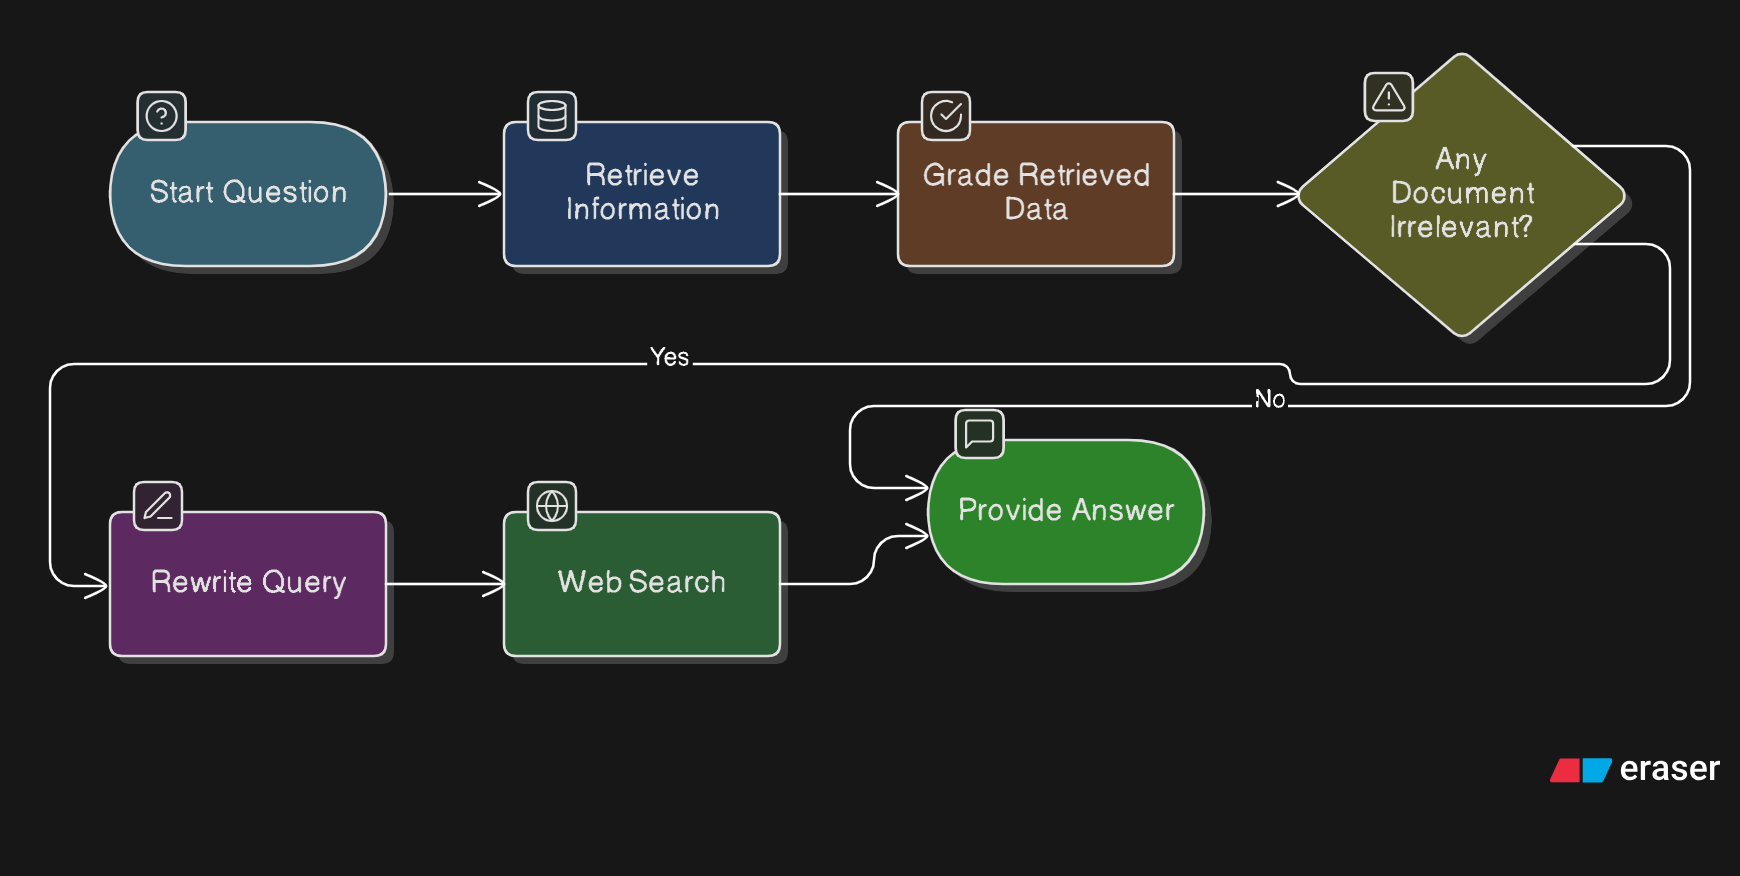

## **System Architecture & Implementation Strategy**

We construct this solution as an **Agentic RAG System** using **LangGraph**, where the entire workflow is modeled as a state machine.

In this architecture, each distinct functionality (Retrieval, Grading, Web Search, Generation) is encapsulated as a **Node** within the graph. The execution flow is governed by **Edges** (conditional logic) that determine the next step based on the LLM's evaluation.

**Key components of the workflow include:**

* **Nodes:** Modular functions where prompts are sent to the LLM to execute specific tasks (e.g., *Is this document relevant?*).
* **State:** A shared data structure that passes context (question, documents, grades) between nodes.
* **Edges:** Logic that routes the control flow (e.g., *If relevant -> Generate*, *If irrelevant -> Web Search*).

---

![demo gif](https://substackcdn.com/image/fetch/$s_!ODLh!,w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Ff071a6b3-e162-4400-92c1-3f8a6c044242_1618x1046.gif)



___Example of Agentic Corrective RAG created By: [Avi Chawla from Daily Dose of Data Science](https://blog.dailydoseofds.com/p/corrective-rag-agentic-workflow)___


## Install Transformers and LangChain dependencies

In [ ]:
%%capture
!pip install -U langchain langchain-community langchain-core langgraph langchain-openai langchain-huggingface langchain-chroma chromadb sentence-transformers duckduckgo-search ddgs

## Build a Search Index for Vietnamese Traditional Medicine Data by `Chroma`

We will build a vector database for retrieval and search from 4 Vietnamese Traditional Medicine Books, includes:
- `2010. Noi Khoa YHCT - GS Hoang Bao Chau. NXB Thoi Dai`
- `bệnh ngũ quan`
- `nhi-khoa-y-hoc-co-truyen`
- `noi-khoa-y-hoc-co-truyen`

### Create VectorDatabase HuggingFace Embedding Models


#### **Why We Chose `BAAI/bge-m3?`**

The selection of **BAAI/bge-m3** (Beijing Academy of Artificial Intelligence - General Embedding, M3 series) is a strategic decision driven by three key requirements: **Language Support**, **Context Length**, and **Retrieval Accuracy**.

##### **1. Superior Multilingual Support (Crucial for Vietnamese)**

Unlike standard embedding models (e.g., `all-MiniLM-L6-v2`) which are primarily optimized for English, **BGE-M3** is designed to be truly multilingual.

* It supports over **100 languages**, including excellent performance on **Vietnamese**.
* This is critical for your project ("Traditional Medicine" data) where specific Vietnamese terminologies (*e.g., "Hư hỏa", "Tạng tượng"*) must be accurately encoded without losing semantic meaning.

##### **2. State-of-the-Art (SOTA) Performance**

BGE-M3 consistently tops the **MTEB (Massive Text Embedding Benchmark)** leaderboard for multilingual retrieval tasks.

* It outperforms standard open-source models and even rivals proprietary models like OpenAI's `text-embedding-3-small`.
* It provides high-quality dense vectors that ensure semantically related documents are retrieved even if the keywords don't match exactly.

##### **3. Massive Context Window (8192 Tokens)**

Traditional BERT-based models usually have a limit of **512 tokens**.

* **BGE-M3 supports up to 8192 tokens.**
* This allows the model to embed long medical documents or large chunks of text without truncation, ensuring that the full context of a disease or treatment is captured in a single vector.

##### **4. The "M3" Advantage**

The "M3" stands for **Multi-Linguality, Multi-Functionality, and Multi-Granularity**.

* It is a hybrid model capable of performing **Dense Retrieval** (Semantic search), **Sparse Retrieval** (Lexical matching like BM25), and **Multi-Vector Retrieval** (ColBERT style) simultaneously.
* While we are currently using it for Dense Retrieval, this choice future-proofs your system, allowing for easy upgrades to Hybrid Search without changing the base model.

### **Comparison Summary**

| Feature | `all-MiniLM-L6-v2` | `OpenAI text-embedding-3` | **`BAAI/bge-m3` (Our Choice)** |
| --- | --- | --- | --- |
| **Vietnamese Support** | Weak | Good | **Excellent** |
| **Max Tokens** | 512 | 8192 | **8192** |
| **Open Source** | Yes | No (Paid) | **Yes** |
| **Retrieval Type** | Dense Only | Dense Only | **Dense + Sparse + Multi-Vector** |

In [ ]:
%%capture
!pip install langchain-huggingface sentence-transformers langchain-community docx2txt gdown

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings

import torch

model_name = "BAAI/bge-m3"

print(f"[PROCESS] Loading Embedding model: {model_name}...")

embedding_model = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cuda'},
    encode_kwargs={'normalize_embeddings': True}
)

print("[SUCCESS] Loaded Embedding Model into GPU!")

[PROCESS] Loading Embedding model: BAAI/bge-m3...


/tmp/ipython-input-1559370641.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

[SUCCESS] Loaded Embedding Model into GPU!


### Upload Vietnamese data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **2010. Noi Khoa YHCT - GS Hoang Bao Chau. NXB Thoi Dai**

In [ ]:
# @title Split chunk
import re
from langchain_community.document_loaders import Docx2txtLoader
from langchain_core.documents import Document

PATH = "/content/drive/MyDrive/Prj_Mid_30_23120271_23120283_23120301_23120333/2010. Noi Khoa YHCT - GS Hoang Bao Chau. NXB Thoi Dai.docx"
loader = Docx2txtLoader(PATH)
raw_text = loader.load()[0].page_content
raw_text = re.sub(r'\n*\s*_{8,}\s*\n*', '\n__________\n', raw_text)
parts = re.split(r'\n__________\n', raw_text)

docs = []
for i, part in enumerate(parts):
    part = part.strip()
    if not part: continue
    lines = [line.strip() for line in part.split('\n') if line.strip()]
    title_line = lines[0] if lines else f"Untitled {i}"
    for line in lines:
        if line.isupper() or (len(line) > 5 and line == line.upper()):
            title_line = line; break

    docs.append(Document(page_content=part, metadata={"title": title_line.strip()}))

PATTERNS = [
    r'^[A-Z]\.\s',
    r'^\d+\.\s',
    r'^\d+\.\d+\.\s',
    r'^[a-zđ]\.\s'
]

def recursive_split(lines, current_title, current_section, pattern_index):
    if pattern_index >= len(PATTERNS):
        content = '\n'.join(lines).strip()
        if not content: return []
        return [Document(
            page_content=content,
            metadata={
                "source": "Noi_Khoa_YHCT_GS_Hoang_Bao_Chau",
                "title": current_title,
                "section": current_section
            }
        )]

    current_pattern = PATTERNS[pattern_index]

    splits = []
    for i, line in enumerate(lines):
        if re.match(current_pattern, line.strip()):
            splits.append((i, line.strip()))

    if not splits:
        return recursive_split(lines, current_title, current_section, pattern_index + 1)

    results = []
    splits = [(0, None)] + splits + [(len(lines), None)]
    splits.sort(key=lambda x: x[0])

    for j in range(len(splits) - 1):
        start_idx, header = splits[j]
        end_idx = splits[j + 1][0]

        sub_lines = lines[start_idx + 1 : end_idx]

        if header is None:
            if not sub_lines: continue

            suffix = " (Dẫn nhập)" if "Dẫn nhập" not in current_section else ""

            new_section_name = f"{current_section}{suffix}"

            processed_docs = recursive_split(sub_lines, current_title, new_section_name, pattern_index + 1)
        else:
            new_section_name = f"{current_section} - {header}"
            content_for_next_level = [header] + sub_lines
            processed_docs = recursive_split(content_for_next_level, current_title, new_section_name, pattern_index + 1)

        results.extend(processed_docs)

    return results

chunks1 = []
main_headers = ["ĐẠI CƯƠNG", "CHỨNG TRỊ", "NGUYÊN NHÂN"]

for index, doc in enumerate(docs):
    part = doc.page_content.strip()
    title = doc.metadata.get("title", "")
    if not part: continue
    lines = part.split('\n')

    splits = []
    for i, line in enumerate(lines):
        clean_header = line.strip().rstrip(':')
        if clean_header in main_headers:
            splits.append((i, clean_header))

    splits = [(0, None)] + splits + [(len(lines), None)]
    splits.sort(key=lambda x: x[0])

    for j in range(len(splits) - 1):
        start_index, header = splits[j]
        end_index = splits[j + 1][0]

        if header is None: continue

        section_lines = lines[start_index + 1 : end_index]
        if not section_lines: continue

        sub_docs = recursive_split(section_lines, title, header, pattern_index=0)

        for sub_doc in sub_docs:
            Content = f"{header}\n\n{sub_doc.page_content}"
            sub_doc.page_content = Content
            chunks1.append(sub_doc)

print(f"[SUCCESS] Number of chunk documents: {len(chunks1)}")


[SUCCESS] Number of chunk documents: 772


### **bệnh ngũ quan**

In [ ]:
# @title Split chunk
import re
from langchain_community.document_loaders import Docx2txtLoader
from langchain_core.documents import Document

file_path = "/content/drive/MyDrive/Prj_Mid_30_23120271_23120283_23120301_23120333/bệnh ngũ quan.docx"
BOOK_NAME = "bệnh ngũ quan"
MARKER_START = "CHÍN (9) ĐIỀU CĂN DẶN"
NO_SPLIT_TITLES = ["CHÍN (9) ĐIỀU CĂN DẶN", "LỜI NÓI ĐẦU"]

loader = Docx2txtLoader(file_path)
raw_text = loader.load()[0].page_content
raw_text = raw_text.replace('</break>', ' ').replace('<break>', ' ')
raw_text = re.sub(r'\n*\s*_{8,}\s*\n*', '\n__________\n', raw_text)
parts = re.split(r'\n__________\n', raw_text)

SUB_PATTERNS = [
    r'^\s*(?:Phần|Chương)?\s*[IVX]+\.[\s\t]*',
    r'^\s*\d+\.[\s\t]*',
    r'^\s*\d+\.\d+\.[\s\t]*',
    r'^\s*[a-zđ]\.[\s\t]*'
]

def recursive_split(lines, current_title, current_section_name, pattern_idx):
    def create_doc(content_lines, section_override=None):
        content = '\n'.join(content_lines).strip()
        if not content: return None
        final_section = section_override if section_override else current_section_name
        full_content = f"{current_title}-{final_section}\nNỘI DUNG:\n{content}"
        return Document(
            page_content=full_content,
            metadata={"source": BOOK_NAME, "title": current_title, "section": final_section}
        )

    if pattern_idx >= len(SUB_PATTERNS):
        doc = create_doc(lines)
        return [doc] if doc else []

    current_pattern = SUB_PATTERNS[pattern_idx]
    splits = []

    for i, line in enumerate(lines):
        line_strip = line.strip()
        is_match = False

        if re.match(current_pattern, line_strip):
            is_match = True

        if not is_match and pattern_idx == 0:
            special_keywords = ["PHỤ LỤC", "PHỤ PHƯƠNG"]
            if any(line_strip.upper().startswith(k) for k in special_keywords):
                is_match = True

        if not is_match and pattern_idx == 1:
            keywords_rescue = ["Phép chữa", "Phương pháp", "Điều trị", "Triệu chứng"]
            if any(line_strip.startswith(k) for k in keywords_rescue) and len(line_strip) < 50:
                is_match = True

        if is_match:
            splits.append((i, line_strip))

    if not splits:
        if pattern_idx == 0:
            doc = create_doc(lines, section_override="Tổng quan")
            return [doc] if doc else []
        else:
            return recursive_split(lines, current_title, current_section_name, pattern_idx + 1)

    results = []
    splits = [(0, None)] + splits + [(len(lines), None)]
    splits.sort(key=lambda x: x[0])

    for j in range(len(splits) - 1):
        start_idx, header = splits[j]
        end_idx = splits[j + 1][0]
        sub_lines = lines[start_idx + 1 : end_idx]
        if not sub_lines: continue

        if header is None:
            suffix = " (Dẫn nhập)" if "Dẫn nhập" not in current_section_name else ""
            final_sec = f"{current_section_name}{suffix}" if current_section_name else "Tổng quan"
            doc = create_doc(sub_lines, section_override=final_sec)
            if doc: results.append(doc)
        else:
            display_header = header

            new_section = display_header if not current_section_name else f"{current_section_name} > {display_header}"


            special_list = ["PHỤ LỤC", "PHỤ PHƯƠNG", "BÀI ĐỌC THÊM"]
            is_special_section = any(k in header.upper() for k in special_list)

            if is_special_section:
                content_next = sub_lines
                next_pattern = 0
            else:
                content_next = [header] + sub_lines
                next_pattern = pattern_idx + 1

            results.extend(recursive_split(content_next, current_title, new_section, next_pattern))

    return results

chunks2 = []
is_phase_2 = False
pre_content = []

active_title = "Tổng quan"
last_processed_title = "Tổng quan"

current_disease_buffer = []

all_lines = []
for part in parts:
    lines = [line.strip() for line in part.split('\n') if line.strip()]
    all_lines.extend(lines)

def process_buffer(lines, title):
    if not lines: return

    if any(k in title.upper() for k in NO_SPLIT_TITLES):
        full = f"{title}-Toàn văn\nNỘI DUNG:\n" + "\n".join(lines)
        chunks2.append(Document(page_content=full, metadata={"source": BOOK_NAME, "title": title, "section": "Toàn văn"}))
        return

    # Split
    chunks2.extend(recursive_split(lines, title, "", pattern_idx=0))


for i, line in enumerate(all_lines):
    line_strip = line.strip()
    if not line_strip: continue

    if not is_phase_2:
        if MARKER_START in line_strip.upper() and not re.search(r'\d+$', line_strip):
            is_phase_2 = True
            if pre_content:
                chunks2.append(Document(page_content=f"PHẦN MỞ ĐẦU / MỤC LỤC\n\n" + "\n".join(pre_content), metadata={"source": BOOK_NAME, "title": BOOK_NAME, "section": "Intro"}))
            active_title = line_strip
            last_processed_title = line_strip
            current_disease_buffer = []
            continue
        pre_content.append(line_strip)
        continue

    # check UPPERCASE
    is_upper = (line_strip.isupper() and len(line_strip) > 5
                and not re.match(SUB_PATTERNS[0], line_strip)
                and not any(bad in line_strip.upper() for bad in ["TRƯỜNG ĐẠI HỌC", "KHOA Y HỌC", "BỘ MÔN", "BỆNH NGŨ QUAN"]))

    # check PHỤ LỤC / PHỤ PHƯƠNG
    is_appendix = any(k in line_strip.upper() for k in ["PHỤ LỤC", "PHỤ PHƯƠNG"])

    if is_upper:
        process_buffer(current_disease_buffer, active_title)
        current_disease_buffer = []

        if is_appendix:
            active_title = f"{last_processed_title} - {line_strip}"
        else:
            active_title = line_strip
            last_processed_title = line_strip

        continue

    current_disease_buffer.append(line_strip)

process_buffer(current_disease_buffer, active_title)
print(f"[SUCCESS] Number of chunk documents: {len(chunks2)}")

[SUCCESS] Number of chunk documents: 125


### **nhi-khoa-y-hoc-co-truyen**

In [ ]:
# @title Split chunk
import re
from langchain_community.document_loaders import Docx2txtLoader
from langchain_core.documents import Document


file_path = "/content/drive/MyDrive/Prj_Mid_30_23120271_23120283_23120301_23120333/nhi-khoa-y-hoc-co-truyen.docx"
raw_text = Docx2txtLoader(file_path).load()[0].page_content


def is_skip(line: str) -> bool:
    line = line.strip()
    return (
        not line
        or line.lower() == "</break>"
        or re.fullmatch(r"_+", line) is not None
    )


lines = [
    line.strip()
    for line in raw_text.split("\n")
    if not is_skip(line)
]


CHAPTER_PATTERN = re.compile(r"^CHƯƠNG\s+([IVXLC]+)", re.I)
LESSON_PATTERN  = re.compile(r"^Bài\s+\d+", re.I)
ROMAN_HEADER    = re.compile(r"^[IVX]+\.\s+.+")              # I., II., III.
NUMBER_HEADER   = re.compile(r"^(\d+(?:\.\d+)*\.)\s+(.+)")   # 1., 1.1., 2.3.4.


def parse_number_path(header: str):
    """
    Convert '1.2.3.' -> [1, 2, 3]
    Used to infer section hierarchy depth
    """
    nums = header.split()[0].strip(".")
    return [int(x) for x in nums.split(".")]



chunks3 = []

current_chapter = None
in_chapter = False

current_lesson = None
current_title = None

section_stack = []            # keep hierarchical headers
content_buffer = []           # collect text for current section


def flush_buffer():
    if not content_buffer or not section_stack:
        return

    full_section = " > ".join(h for _, h in section_stack)
    leaf_header = section_stack[-1][1]

    chunks3.append(
        Document(
            page_content="\n".join([leaf_header] + content_buffer).strip(),
            metadata={
                "source": "nhi-khoa-y-hoc-co-truyen",
                "title": current_title,
                "section": full_section
            }
        )
    )
    content_buffer.clear()


for line in lines:

    # ---- CHAPTER ----
    chap_match = CHAPTER_PATTERN.match(line)
    if chap_match:
        flush_buffer()
        current_chapter = chap_match.group(1)
        in_chapter = True

        # reset chapter-level state
        current_lesson = None
        current_title = None
        section_stack.clear()
        continue

    if not in_chapter:
        continue

    # ---- LESSON ----
    if LESSON_PATTERN.match(line):
        flush_buffer()
        section_stack.clear()
        current_lesson = line
        current_title = None
        continue

    # ---- LESSON TITLE (UPPERCASE) ----
    if current_lesson and not current_title and line.isupper():
        current_title = line
        continue

    if not current_title:
        continue

    # ---- ROMAN SECTIONS (I., II., ...) ----
    if ROMAN_HEADER.match(line):
        flush_buffer()
        section_stack = [(1, line)]
        continue

    # ---- NUMBERED SECTIONS (1., 1.1., ...) ----
    num_match = NUMBER_HEADER.match(line)
    if num_match:
        # Chapter I: chỉ tách tới I., II. theo yêu cầu
        if current_chapter == "I":
            continue

        flush_buffer()

        level = len(parse_number_path(line)) + 1

        # pop stack until correct parent level
        while section_stack and section_stack[-1][0] >= level:
            section_stack.pop()

        section_stack.append((level, line))
        continue

    # ---- CONTENT ----
    if section_stack:
        content_buffer.append(line)


flush_buffer()

print(f"[SUCCESS] Number of chunk documents: {len(chunks3)}")


[SUCCESS] Number of chunk documents: 162


### **noi-khoa-y-hoc-co-truyen**

In [ ]:
# @title Split chunk
import re
import os
from langchain_community.document_loaders import Docx2txtLoader
from langchain_core.documents import Document

file_path = "/content/drive/MyDrive/Prj_Mid_30_23120271_23120283_23120301_23120333/noi-khoa-y-hoc-co-truyen.docx"

if not os.path.exists(file_path):
    print(f"Không tìm thấy file tại: {file_path}")
else:
    loader = Docx2txtLoader(file_path)
    raw_text = loader.load()[0].page_content

    chapter_pattern = r'(?m)^(?![0-9]+\.|I+\.|V\.)(?![a-z])([A-ZÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚĂĐĨŨƠƯĂẠẢẤẦẨẪẬẮẰẲẴẶẸẺẼỀỀỂỄỆỈỊỌỎỐỒỔỖỘỚỜỞỠỢỤỦỨỪỬỮỰỲỴÝỶỸ\s,()-]{3,})$'

    raw_text_processed = re.sub(chapter_pattern, r'\n__________\n\1', raw_text)
    parts = re.split(r'\n__________\n', raw_text_processed)

    docs_by_section = []
    for part in parts:
        part = part.strip()
        lines = [line.strip() for line in part.split('\n') if line.strip()]
        if not lines or len(part) < 50: continue
        title_line = lines[0]
        docs_by_section.append(Document(page_content=part, metadata={"title": title_line}))

    SUB_PATTERNS = [
        r'^\d+\.\s+[A-ZÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚĂĐĨŨƠƯĂẠẢẤẦẨẪẬẮẰẲẴẶẸẺẼỀỀỂỄỆỈỊỌỎỐỒỔỖỘỚỜỞỠỢỤỦỨỪỬỮỰỲỴÝỶỸ]',
        r'^\d+\.\d+\.\s',
        r'^\d+\.\d+\.\d+\.\s',
        r'^[a-zđ]\.\s',
    ]

    def recursive_split(lines, current_title, current_section_name, pattern_idx):
        if pattern_idx >= len(SUB_PATTERNS):
            content = '\n'.join(lines).strip()
            if not content: return []
            return [Document(
                page_content=content,
                metadata={
                    "disease": current_title,
                    "section": current_section_name,
                    "source": "noi-khoa-y-hoc-co-truyen"
                }
            )]

        current_pattern = SUB_PATTERNS[pattern_idx]

        splits = []
        for i, line in enumerate(lines):
            if re.match(current_pattern, line.strip()):
                splits.append((i, line.strip()))

        if not splits:
            return recursive_split(lines, current_title, current_section_name, pattern_idx + 1)

        results = []
        splits = [(0, None)] + splits + [(len(lines), None)]

        for j in range(len(splits) - 1):
            start_idx, header = splits[j]
            end_idx = splits[j + 1][0]
            sub_lines = lines[start_idx + 1 : end_idx]

            if header is None:
                if not sub_lines: continue
                suffix = " (Dẫn nhập)" if "Dẫn nhập" not in current_section_name else ""
                new_section_name = f"{current_section_name}{suffix}"
                processed_docs = recursive_split(sub_lines, current_title, new_section_name, pattern_idx + 1)
            else:
                new_section_name = f"{current_section_name} > {header}"
                content_for_next_level = [header] + sub_lines
                processed_docs = recursive_split(content_for_next_level, current_title, new_section_name, pattern_idx + 1)

            results.extend(processed_docs)
        return results

    refined_docs = []

    for doc in docs_by_section:
        part = doc.page_content.strip()
        title = doc.metadata.get("title", "")
        lines = part.split('\n')
        sub_docs = recursive_split(lines, title, title, pattern_idx=0)
        refined_docs.extend(sub_docs)

    chunks4 = [d for d in refined_docs if "</break>" not in d.metadata.get('disease', '')]

print(f"[SUCCESS] Number of chunk documents: {len(chunks4)}")

[SUCCESS] Number of chunk documents: 1723


### Create a Vector DB and persist on disk

Here we initialize a connection to a Chroma vector DB client, and also we want to save to disk, so we simply initialize the Chroma client and pass the directory where we want the data to be saved to.

In [ ]:
import os, shutil

path = "/content/YHCT"

if os.path.exists(path):
    shutil.rmtree(path)
    print("[SUCCESS] Removed old Chroma directory")


from langchain_chroma import Chroma
Chunks = []
Chunks.extend(chunks1)
Chunks.extend(chunks2)
Chunks.extend(chunks3)
Chunks.extend(chunks4)
# create vector DB of docs and embeddings - takes < 30s on Colab
chroma_db = Chroma.from_documents(
                                #   documents=chunked_docs,
                                  documents=Chunks,
                                  collection_name='y_hoc_co_truyen',
                                #   embedding=openai_embed_model,
                                  embedding=embedding_model,
                                  # need to set the distance function to cosine else it uses euclidean by default
                                  # check https://docs.trychroma.com/guides#changing-the-distance-function
                                  collection_metadata={"hnsw:space": "cosine"},
                                  persist_directory="./YHCT")
print(f"[SUCCESS] Number of chunks: {chroma_db._collection.count()}")

[SUCCESS] Number of chunks: 2782


### Setup a Vector Database Retriever


#### **Justification for "Similarity with Threshold" Strategy**

We employ a **Similarity Search with a Score Threshold** instead of a standard fixed-k retrieval (e.g., "always get top 5"). This decision is driven by the need for **Precision** and **Semantic Understanding** in a specialized medical domain.

##### **Capturing Semantic Meaning (Why Similarity?)**

Traditional keyword search (like BM25) relies on exact word matches. However, in the medical field (especially Traditional Medicine), users often describe symptoms using common language, while the source documents use technical terminology.

* **Example:** A user might ask about *"feeling hot inside"* (nóng trong người), while the document discusses *"Internal Heat"* (Nội nhiệt).
* **Benefit:** Vector Similarity (using Cosine Similarity) maps these concepts close together in the vector space, allowing the system to retrieve relevant documents even without exact keyword overlap.

##### **Quality Control & Noise Reduction (Why Threshold?)**

A standard retriever (e.g., `k=4`) **always** returns 4 documents, even if the database contains nothing relevant to the question. This forces the LLM to hallucinate an answer based on irrelevant "garbage" context.

* **The Threshold Mechanism:** By setting a similarity threshold (e.g., `score_threshold=0.5`), we tell the system: *"If the best document found is not similar enough to the question, discard it."*
* **Benefit:** This acts as a **safety filter**. It prevents the system from feeding irrelevant information to the LLM. If no documents pass the threshold, the system knows it lacks knowledge, which is the perfect trigger for the **Corrective (CRAG)** mechanism to switch to **Web Search**.

#### **Summary**

| Feature | Standard `k=5` Retrieval | **Similarity + Threshold** |
| --- | --- | --- |
| **Behavior** | Always returns 5 docs, regardless of quality. | Returns only docs that meet a quality standard. |
| **Risk** | High risk of hallucination if data is missing. | Low risk; filters out irrelevant noise. |
| **CRAG Fit** | Weak (Hard to detect when to search web). | **Strong** (Empty result = Immediate signal to Search Web). |


### Similarity with Threshold Retrieval

We use cosine similarity here and retrieve the top 3 similar documents based on the user input query and also introduce a cutoff to not return any documents which are below a certain similarity threshold

In [ ]:
similarity_threshold_retriever = chroma_db.as_retriever(search_type="similarity_score_threshold",
                                                        search_kwargs={"k": 3,
                                                                       "score_threshold": 0.3})

In [ ]:
query = "Cảm mạo là bệnh gì?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(id='bedf6b7e-ebb1-4448-902c-5df05f411509', metadata={'source': 'Noi_Khoa_YHCT_GS_Hoang_Bao_Chau', 'section': 'ĐẠI CƯƠNG', 'title': 'CẢM MẠO'}, page_content='ĐẠI CƯƠNG\n\nCảm mạo là cảm nhiễm phải tà khí của bốn mùa trong\n\nnăm, song thường gặp vào mùa xuân, mùa đông.\n\nNguyên nhân là "Khí hậu trái thường của thời tiết, như\n\nmùa xuân đáng ấm mà lại rét, mùa hè đáng nóng mà lại\n\nmát, mùa thu đáng mát mà lại nóng; mùa đông đáng rét\n\nmà lại ấm. Các khí hậu trái thường đó xâm nhập vào cơ\n\nthể mà sinh ra, nặng lắm thì gọi là trúng, vừa vừa thì gọi\n\nlà thương và nhẹ thì gọi là cảm" (Nam dược thần hiệu - \n\nCảm mạo). Trương Cảnh Nhạc cho là bệnh thương phong\n\ngốc là ngoại cảm, nếu tà nặng vào sâu ở kinh lạc là bệnh\n\nthương hàn, nếu là nhẹ mà ở nông chỉ phạm da lông là\n\nbệnh thương phong (thương phong chi bệnh bản do ngoại\n\ncảm, đãn tà thậm nhi thâm giả, truyền kinh lạc, tức vi\n\nthương hàn; tà khinh nhi thiển giả, chỉ phạm bì mao, tức\n\nvi thương phong). Du căn

In [ ]:
query = "Chứng tý là bệnh gì?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(id='057d5bc3-8989-47d0-9a77-616ec7cce21e', metadata={'source': 'noi-khoa-y-hoc-co-truyen', 'disease': 'CHỨNG TÝ', 'section': 'CHỨNG TÝ (Dẫn nhập)'}, page_content='(Viêm đa khớp dạng thấp)\n\n"Tý" là bế lại, là có nghĩa ngăn lấp không thông. "Chứng tý" là một\n\nloại bệnh do tà ở ngoài xâm lấn vào ngăn lấp đường kinh lạc, làm cho cơ\n\nnhục khớp đau nhức sưng to, nặng nề.\n\n"Chứng tý" trong sách "Nội kinh" bàn luận rất nhiều, căn cứ vào\n\nnguyên nhân phát bệnh và chứng trạng hiện ra, mà chia ra thành "hành\n\ntý", "thống tý", "trước tý", lại còn lấy sự khác nhau về thời tiết phát bệnh,\n\nbộ vị tà khí xâm phạm vào, và chứng trạng mà chia ra các chứng "cân tý"\n\n"cơ tý", "mạch tý", "bì tý". Cách phân chia này trên thực tế vẫn thuộc trong\n\nphạm vi của ba chứng tý mà thôi, đúng như trong sách "Kim quỹ" nói:\n\n"Nội kinh" bàn về chứng tý mà có chia ra 5 chứng tý là: Cốt tý, Cân tý,\n\nMạch tý, Cơ tý, Bì tý. Đại khái là căn cứ vào 3 chứng tý: Phong, Hàn,\n\nThấp, rồi theo vào 

## SetUp & Load Model

In [ ]:
# @title Load Model
from langchain_huggingface import ChatHuggingFace, HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.runnables import RunnableLambda
from pydantic import BaseModel, Field
from operator import itemgetter
import torch

model_id = "Qwen/Qwen2.5-7B-Instruct"
print(f"[INIT] Loading Model {model_id} into GPU (One-time only)...")

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

shared_pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=2048,
    do_sample=False,
    repetition_penalty=1.1,
    return_full_text=False
)


llm_pipeline = HuggingFacePipeline(pipeline=shared_pipe)

shared_chat_model = ChatHuggingFace(llm=llm_pipeline)

print("[SUCCESS] Model loaded successfully! Shared object created.")



[INIT] Loading Model Qwen/Qwen2.5-7B-Instruct into GPU (One-time only)...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[SUCCESS] Model loaded successfully! Shared object created.


## Create a Query Retrieval Grader

Here we will use an LLM itself to grade if any retrieved document is relevant to the given question - Answer will be either `yes` or `no`

In [ ]:
# @title Grader

print("\n--- [SETUP] Grader Chain ---")

def parse_grader_output(text: str):
    return {"binary_score": "yes" if "yes" in text.lower() else "no"}

SYS_PROMPT_GRADER = """You are a grader assessing relevance of a retrieved document to a user question.
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages([
    ("system", SYS_PROMPT_GRADER),
    ("human", "Doc:\n{document}\n\nQuestion: {question}"),
])

# Chain: Prompt -> SHARED MODEL -> Parser
doc_grader = grade_prompt | shared_chat_model | StrOutputParser() | parse_grader_output
print("[SUCCESS] Grader Chain created.")



--- [SETUP] Grader Chain ---
[SUCCESS] Grader Chain created.


## Create a Query Rephraser

We will now build a query rephraser which will use an LLM to rephrase the input user query into a better version which is optimized for web search

In [ ]:
# @title Rewriter

print("\n--- [SETUP] Rewriter Chain ---")

SYS_PROMPT_REWRITE = """Act as a question re-writer.
Convert the input question to a better version optimized for vector search.
Output ONLY the improved question text. No explanation."""

rewrite_prompt = ChatPromptTemplate.from_messages([
    ("system", SYS_PROMPT_REWRITE),
    ("human", "Question:\n{question}\n\nImproved question:"),
])

# Chain: Prompt -> SHARED MODEL -> Parser
question_rewriter = rewrite_prompt | shared_chat_model | StrOutputParser()
print("[SUCCESS] Rewriter Chain created.")



--- [SETUP] Rewriter Chain ---
[SUCCESS] Rewriter Chain created.


## Build a QA RAG Chain

We will now connect our retriever to an LLM and build our QA RAG Chain

In [ ]:
# @title Generator
print("\n--- [SETUP] Generator Chain ---")

prompt_gen_text = """You are an assistant for question-answering tasks.
Use the provided context to answer the question.
If you don't know, say so. Keep the answer detailed.

Question: {question}
Context: {context}
Answer:"""

prompt_gen = ChatPromptTemplate.from_template(prompt_gen_text)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain: Prompt -> SHARED MODEL -> Parser
qa_rag_chain = (
    {
        "context": (itemgetter('context') | RunnableLambda(format_docs)),
        "question": itemgetter('question')
    }
    | prompt_gen
    | shared_chat_model # Vẫn dùng biến model chung này
    | StrOutputParser()
)
print("[SUCCESS] Generator Chain created.")

print("\n[SUCCESS] All chains are ready using a SINGLE model instance!")


--- [SETUP] Generator Chain ---
[SUCCESS] Generator Chain created.

[SUCCESS] All chains are ready using a SINGLE model instance!


## Load Web Search Tool

Here we will be using the
[DuckDuckGoSearch](https://pypi.org/project/duckduckgo-search/)
for our web searches
<!-- [Tavily API](https://tavily.com/#api) -->

In [ ]:
# @title DuckDuckGo WebSearch Tool
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_core.tools import Tool

ddg_search = DuckDuckGoSearchResults(backend="api", num_results=3)

web_search_tool = Tool(
    name="web_search",
    description="Search the internet for current events or general knowledge.",
    func=ddg_search.invoke
)

print("Create DuckDuckGo (Web Search Tool) successfully")

Create DuckDuckGo (Web Search Tool) successfully


## Build Agentic RAG components

Here we will build the key components of our Agentic Corrective RAG System as per the workflow below:

<!-- ![](https://i.imgur.com/uhybMhT.png) -->



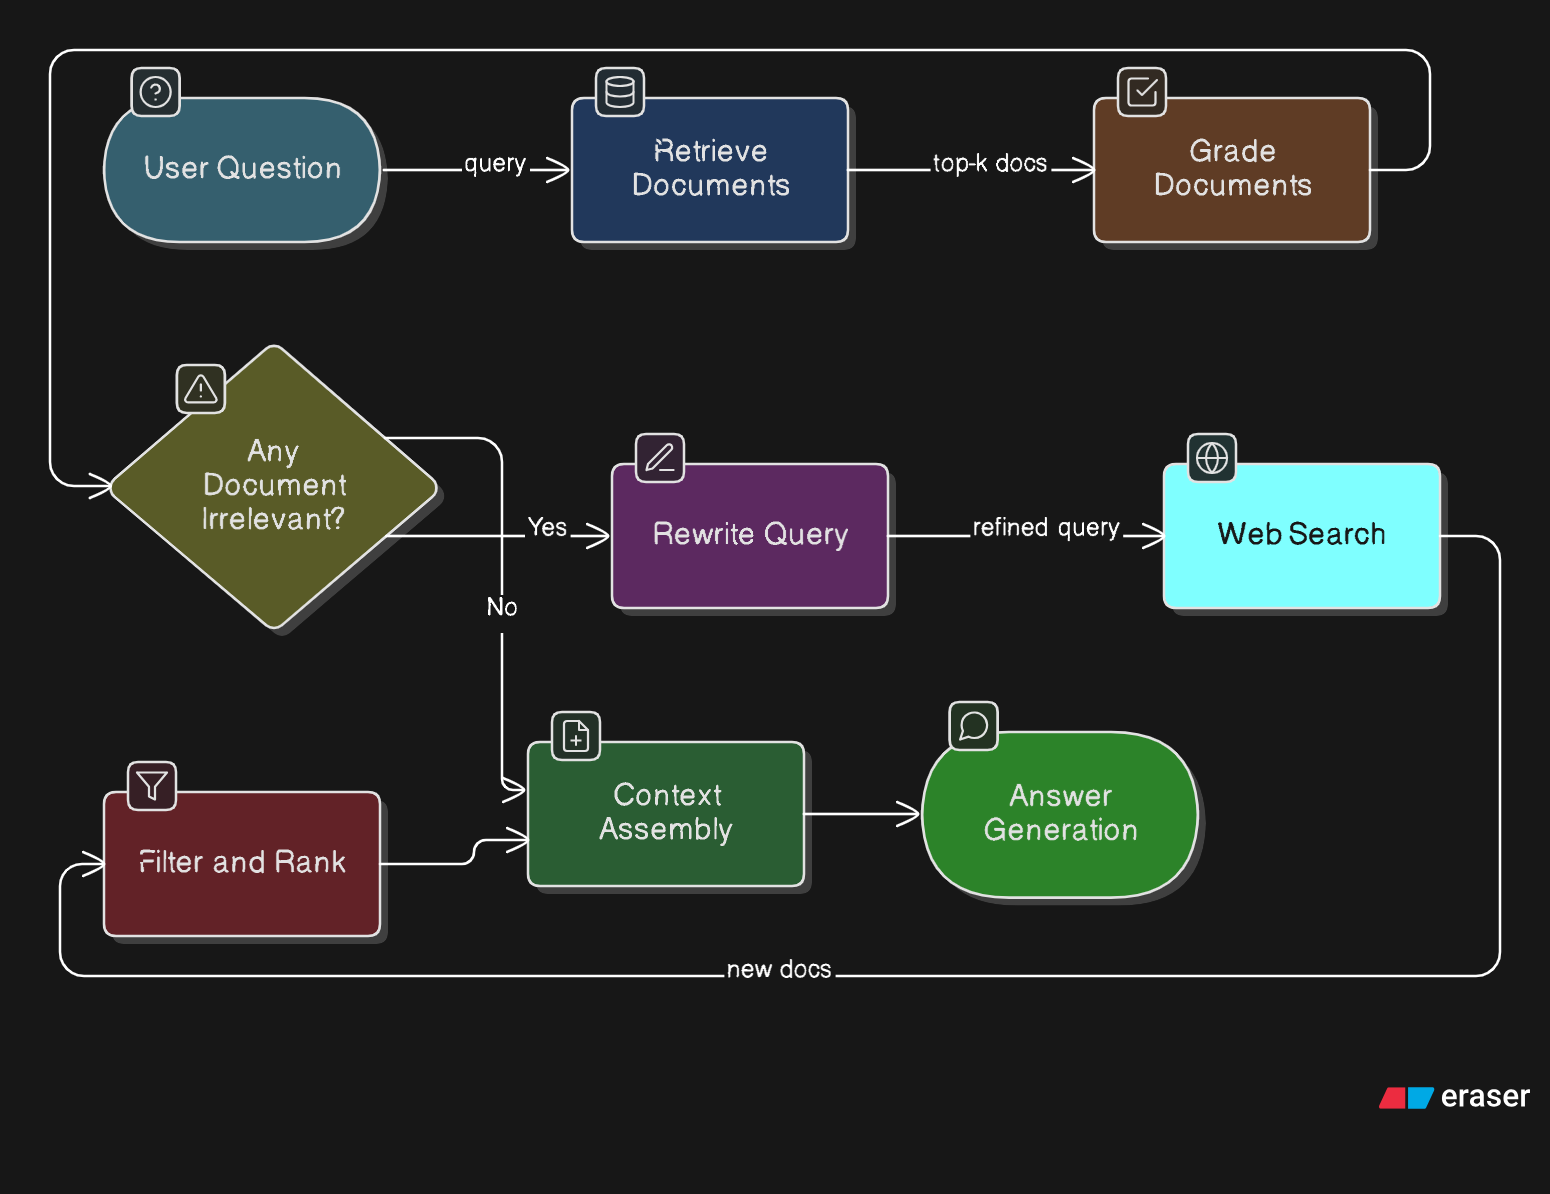

### Graph State

Used to store and represent the state of the agent graph as we traverse through various nodes

In [ ]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM response generation
        web_search_needed: flag of whether to add web search - yes or no
        documents: list of context documents
    """

    question: str
    generation: str
    web_search_needed: str
    documents: List[str]

### Retrieve function for retrieval from Vector DB

This will be used to get relevant context documents from the vector database

In [ ]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents - that contains retrieved context documents
    """
    print("\n[PROCESS] RETRIEVAL FROM VECTOR DATABASE")
    question = state["question"]

    # Retrieval
    documents = similarity_threshold_retriever.invoke(question)
    return {"documents": documents, "question": question}

### Grade documents

#### **Innovation: Hybrid Retrieval-Grading Strategy**

Unlike the standard CRAG architecture which typically relies on a single lightweight evaluator (e.g., T5-large) to classify documents, our system implements a **Hybrid Ensemble Scoring Mechanism**. This approach combines the semantic precision of a **Cross-Encoder Re-ranker** with the reasoning capabilities of a **Generative LLM**.

##### **1. Why move beyond Standard CRAG?**

Standard CRAG relies heavily on a single model's judgment. In resource-constrained environments (e.g., using smaller LLMs like Qwen-1.5B), this single point of failure can lead to:

* **False Positives:** The LLM might hallucinate and classify an irrelevant document as "relevant" just because it shares some keywords.
* **Lack of Granularity:** A simple "Yes/No" classification fails to capture *how* relevant a document is.

##### **2. The "Two-Judge" System**

Our proposed solution employs two distinct judges to evaluate every document:

* **Judge 1: The Cross-Encoder (Discriminative Model)**
    * **Model:** `BAAI/bge-reranker-base`.
    * **Role:** Calculates a precise semantic similarity score (0 to 1). Cross-encoders are specialized in understanding the relationship between a query and a passage, often outperforming LLMs in pure relevance detection.
    * **Strength:** Catches subtle semantic mismatches that generative models might miss.


* **Judge 2: The LLM Grader (Generative Model)**
    * **Model:** `Qwen-7B-Instruct`.
    * **Role:** Performs logical verification. It checks if the document actually *contains the answer* to the specific question, rather than just being about the same topic.
    * **Strength:** Understands complex instructions and context.



##### **3. Weighted Fusion Logic**

We fuse these two signals using a weighted formula to derive a **Final Confidence Score**:

* We assign **Re-ranker** and **LLM**.
* **Rationale:** We prioritize the Re-ranker because it is a specialized SOTA model for relevance, acting as a stabilizer for the potentially "noisy" generation of the smaller LLM.

##### **4. Comparative Advantage**

| Feature | Standard CRAG (Paper Implementation) | **Our Hybrid Approach** |
| --- | --- | --- |
| **Evaluator** | Single Model (T5 or LLM) | **Ensemble (Cross-Encoder + LLM)** |
| **Output** | Discrete Class (Correct/Ambiguous/Incorrect) | **Continuous Probability Score (0.0 - 1.0)** |
| **Robustness** | Susceptible to single-model errors | **High** (One model corrects the other) |
| **Flexibility** | Fixed decision logic | **Adjustable Threshold** (e.g., > 0.5) |


In [ ]:
from sentence_transformers import CrossEncoder
import numpy as np

print("[PROCESS] Loading Re-ranker Model...")
reranker_model = CrossEncoder('BAAI/bge-reranker-base', device='cuda')
print("[SUCCESS] Loaded Re-ranker Model")

def calculate_score(doc_txt, question, llm_grade):
    """
    Tính điểm tổng hợp:
    - Re-ranker score (Normalized 0-1)
    - LLM Grade (Normalized 0-1 từ thang 1-5)
    """

    rerank_score = reranker_model.predict([(question, doc_txt)])[0]
    rerank_norm = 1 / (1 + np.exp(-rerank_score))

    if isinstance(llm_grade, str):
        llm_norm = 1.0 if llm_grade.lower() == "yes" else 0.0
    else:
        llm_norm = float(llm_grade) / 5.0

    weight_rerank = 0.6
    weight_llm = 0.4

    final_score = (rerank_norm * weight_rerank) + (llm_norm * weight_llm)
    return final_score

def grade_documents_hybrid(state):
    """
    Hybrid Re-ranker & LLM
    """
    print("[PROCESS] HYBRID RELEVANCE")
    question = state["question"]
    documents = state["documents"]

    filtered_docs = []
    web_search_needed = "No"

    THRESHOLD = 0.5

    if documents:
        for d in documents:
            llm_res = doc_grader.invoke({"question": question, "document": d.page_content})

            if isinstance(llm_res, dict):
                llm_val = llm_res.get("binary_score", "no")
            else:
                llm_val = getattr(llm_res, "binary_score", "no")

            final_score = calculate_score(d.page_content, question, llm_val)

            print(f"\tDocumnent: {d.metadata.get('title', 'Unknown')} | Score: {final_score:.2f}")

            if final_score >= THRESHOLD:
                filtered_docs.append(d)
            else:
                continue

        if not filtered_docs:
            web_search_needed = "Yes"
            print("\t[PROCESS] Need Web Search")

    else:
        web_search_needed = "Yes"

    return {"documents": filtered_docs, "question": question, "web_search_needed": web_search_needed}

[PROCESS] Loading Re-ranker Model...


config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

[SUCCESS] Loaded Re-ranker Model


### Rewrite query

This will be used to rewrite the input query to produce a better question optimized for web search using an LLM

In [ ]:
def rewrite_query(state):
    """
    Rewrite the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased or re-written question
    """

    print("[PROCESS] REWRITE QUERY")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

### Web Search

This will be used to search the web using the web search tool for the given query and retrieve some information which can be used as the context in RAG

In [ ]:
from ddgs import DDGS
from langchain_core.documents import Document

def web_search(state):
    """
    Web search using the new 'ddgs' library.
    """
    print("[PROCESS] WEB SEARCH (DuckDuckGo)")
    question = state["question"]

    documents = state.get("documents", [])
    if documents is None:
        documents = []

    web_results_content = ""

    try:
        with DDGS() as ddg:
            results = list(ddg.text(question, max_results=3))

            if results:
                web_results_content = "\n\n".join(
                    [f"Title: {d.get('title', '')}\nLink: {d.get('href', '')}\nContent: {d.get('body', d.get('snippet', ''))}"
                     for d in results]
                )
            else:
                web_results_content = "[ERROR] Not Found"

    except Exception as e:
        print(f"[ERROR] {e}")
        web_results_content = f"[ERROR] {e}"

    web_doc = Document(
        page_content=web_results_content,
        metadata={"source": "duckduckgo_search"}
    )

    documents.append(web_doc)

    return {"documents": documents, "question": question}

### Generate Answer

Standard LLM Response generation from query and context documents in a RAG system

In [ ]:
def generate_answer(state):
    """
    Generate answer from context document using LLM

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("[PROCESS] GENERATE ANSWER")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = qa_rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

### Decide to Generate

This will be used as a conditional function which will check the `web_search_needed` flag and decide if a web search is needed or a response should be generated and return the function name to be called

In [ ]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("[PROCESS] ASSESS GRADED DOCUMENTS")
    web_search_needed = state["web_search_needed"]

    if web_search_needed == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("[PROCESS] DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY")
        return "rewrite_query"
    else:
        # We have relevant documents, so generate answer
        print("[PROCESS] DECISION: GENERATE RESPONSE")
        return "generate_answer"

### Build the Agent Graph

Here we will use LangGraph and build the agent as a graph

In [ ]:
from langgraph.graph import END, StateGraph

agentic_rag = StateGraph(GraphState)

# Define the nodes
agentic_rag.add_node("retrieve", retrieve)  # retrieve
agentic_rag.add_node("grade_documents", grade_documents_hybrid)  # grade documents
agentic_rag.add_node("rewrite_query", rewrite_query)  # transform_query
agentic_rag.add_node("web_search", web_search)  # web search
agentic_rag.add_node("generate_answer", generate_answer)  # generate answer

# Build graph
agentic_rag.set_entry_point("retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")
agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate_answer": "generate_answer"},
)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)

# Compile
agentic_rag = agentic_rag.compile()

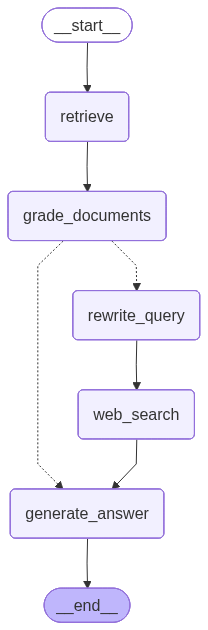

In [ ]:
from IPython.display import Image, display, Markdown

display(Image(agentic_rag.get_graph().draw_mermaid_png()))

## Test the Agentic CRAG System

In [ ]:
query = "Ngũ tạng bao gồm những thứ gì?"

# --- Truyền full state ---
inputs = {
    "question": query,
    "documents": [],  # Khởi tạo danh sách rỗng
    "generation": ""  # Khởi tạo chuỗi rỗng
}

response = agentic_rag.invoke(inputs)


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: Unknown | Score: 0.84
	Documnent: Unknown | Score: 0.72
	Documnent: Unknown | Score: 0.30
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


In [ ]:
display(Markdown(response['generation']))

Ngũ tạng trong y học cổ truyền bao gồm năm tạng chính: tâm, can, tỳ, phế và thận. Ngoài ra, còn có một số cấu trúc khác được coi là thuộc về "lục phủ" (bảy tạng) và "phủ kỳ hằng". Cụ thể:

1. Ngũ tạng chính:
   - Tâm: Quản lý trí nhớ, tình cảm và giấc ngủ.
   - Can: Điều hòa khí huyết, quản lý sự vận hành của gan.
   - Tỳ: Trị tiêu hóa, hấp thu dưỡng chất.
   - Phế: Quản lý hô hấp và hệ miễn dịch.
   - Thận: Quản lý sinh lực cơ bản, phát triển và trưởng thành.

2. Lục phủ (bảy tạng):
   - Đởm: Thường được xem như một phần của can, liên quan đến sinh lực sinh sản.
   
3. Phủ kỳ hằng:
   - Vị: Quản lý tiêu hóa.
   - Đại trường: Hỗ trợ quá trình tiêu hóa và bài tiết.
   - Bàng quang: Quản lý nước tiểu.

4. Ngũ quan (sáu quan):
   - Mắt: Liên quan đến can.
   - Tai: Liên quan đến thận.
   - Miệng: Liên quan đến tỳ.
   - Lưỡi: Liên quan đến can.
   - Mũi: Liên quan đến phế.
   - Da: Liên quan đến phế.

5. Cửu khiếu (chín lỗ):
   - Tai: Hai bên.
   - Mũi: Hai bên.
   - Môi trên và môi dưới: Hai bên.
   - Mắt: Hai bên.
   - Răng: Hai bên.
   - Kẽ ngón tay: Hai bên.

6. Khác:
   - Não tuỷ: Liên quan đến tâm và thận.
   - Cốt mạch: Liên quan đến can và thận.
   - Tử cung: Liên quan đến can và thận.
   - Kinh lạc: Hệ thống đường dẫn khí huyết khắp cơ thể.
   - Khí huyết: Nguyên khí và máu.
   - Dinh vệ: Nước uống và thức ăn.
   - Tinh thần: Tinh thần và ý chí.
   - Tân dịch: Nước bọt và nước miếng.
   - Da, lông, gân, thịt, tóc: Các mô và cơ quan ngoại vi.

Những cấu trúc này được kết hợp để tạo nên một hệ thống toàn diện trong y học cổ truyền, nơi mỗi bộ phận có mối liên hệ chặt chẽ với các bộ phận khác và với môi trường xung quanh.

In [ ]:
response

{'question': 'Ngũ tạng bao gồm những thứ gì?',
 'generation': 'Ngũ tạng trong y học cổ truyền bao gồm năm tạng chính: tâm, can, tỳ, phế và thận. Ngoài ra, còn có một số cấu trúc khác được coi là thuộc về "lục phủ" (bảy tạng) và "phủ kỳ hằng". Cụ thể:\n\n1. Ngũ tạng chính:\n   - Tâm: Quản lý trí nhớ, tình cảm và giấc ngủ.\n   - Can: Điều hòa khí huyết, quản lý sự vận hành của gan.\n   - Tỳ: Trị tiêu hóa, hấp thu dưỡng chất.\n   - Phế: Quản lý hô hấp và hệ miễn dịch.\n   - Thận: Quản lý sinh lực cơ bản, phát triển và trưởng thành.\n\n2. Lục phủ (bảy tạng):\n   - Đởm: Thường được xem như một phần của can, liên quan đến sinh lực sinh sản.\n   \n3. Phủ kỳ hằng:\n   - Vị: Quản lý tiêu hóa.\n   - Đại trường: Hỗ trợ quá trình tiêu hóa và bài tiết.\n   - Bàng quang: Quản lý nước tiểu.\n\n4. Ngũ quan (sáu quan):\n   - Mắt: Liên quan đến can.\n   - Tai: Liên quan đến thận.\n   - Miệng: Liên quan đến tỳ.\n   - Lưỡi: Liên quan đến can.\n   - Mũi: Liên quan đến phế.\n   - Da: Liên quan đến phế.\n\n5

In [ ]:
query = "Triệu chứng và cách điều trị bệnh Trúng thử?"
response = agentic_rag.invoke({"question": query})


[PROCESS]RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: TRÚNG THỬ (SAY NẮNG) | Score: 0.76
	Documnent: TRÚNG HÀN | Score: 0.43
	Documnent: Unknown | Score: 0.34
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


In [ ]:
display(Markdown(response['generation']))

Triệu chứng của bệnh trúng thử bao gồm:

1. Người đang làm việc ở nơi nắng gắt đột nhiên ngã vật ra bất tỉnh nhân sự.
2. Da rất nóng, có mồ hôi (ít hoặc nhiều).
3. Thở dốc, không nói được.
4. Răng cắn chặt hoặc miệng há mở.
5. Lưỡi đỏ.
6. Mạch hồng nhu hoặc sác.

Bệnh này thường xảy ra vào các thời điểm như tiết tiểu thử, đại thử, xử thứ - những lúc nội kinh gọi là "tam phục".

Nguyên nhân của bệnh trúng thử là do thử nhiệt đã vượt qua dương minh (vệ khi) để tấn công trực tiếp vào tạng phủ (dinh huyết).

Cách điều trị:
Để điều trị bệnh trúng thử, cần thực hiện các biện pháp sau:

1. Chuyển người bệnh đến nơi thoáng mát, tránh tiếp xúc với ánh nắng mặt trời.
2. Cho uống nước muối loãng hoặc nước lạnh để hạ nhiệt cơ thể.
3. Sử dụng các phương pháp giải nhiệt như chườm lạnh lên trán, cổ, nách và bẹn.
4. Nếu tình trạng nặng, cần đưa người bệnh đến bệnh viện để được cấp cứu kịp thời.
5. Theo dõi sát sao tình trạng của người bệnh, đặc biệt là nhịp tim, huyết áp và hô hấp.
6. Khi đã ổn định, nên cho người bệnh nghỉ ngơi đầy đủ và bổ sung dinh dưỡng.

Lưu ý rằng đây chỉ là hướng dẫn sơ cứu ban đầu. Trường hợp nặng hoặc kéo dài, cần phải có sự can thiệp của bác sĩ chuyên khoa.

In [ ]:
response

{'question': 'Triệu chứng và cách điều trị bệnh Trúng thử?',
 'generation': 'Triệu chứng của bệnh trúng thử bao gồm:\n\n1. Người đang làm việc ở nơi nắng gắt đột nhiên ngã vật ra bất tỉnh nhân sự.\n2. Da rất nóng, có mồ hôi (ít hoặc nhiều).\n3. Thở dốc, không nói được.\n4. Răng cắn chặt hoặc miệng há mở.\n5. Lưỡi đỏ.\n6. Mạch hồng nhu hoặc sác.\n\nBệnh này thường xảy ra vào các thời điểm như tiết tiểu thử, đại thử, xử thứ - những lúc nội kinh gọi là "tam phục".\n\nNguyên nhân của bệnh trúng thử là do thử nhiệt đã vượt qua dương minh (vệ khi) để tấn công trực tiếp vào tạng phủ (dinh huyết).\n\nCách điều trị:\nĐể điều trị bệnh trúng thử, cần thực hiện các biện pháp sau:\n\n1. Chuyển người bệnh đến nơi thoáng mát, tránh tiếp xúc với ánh nắng mặt trời.\n2. Cho uống nước muối loãng hoặc nước lạnh để hạ nhiệt cơ thể.\n3. Sử dụng các phương pháp giải nhiệt như chườm lạnh lên trán, cổ, nách và bẹn.\n4. Nếu tình trạng nặng, cần đưa người bệnh đến bệnh viện để được cấp cứu kịp thời.\n5. Theo dõi

In [ ]:
query = "Nguyên nhân gây ra chứng Trúng thử?"
response = agentic_rag.invoke({"question": query})


[PROCESS]RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


	Documnent: TRÚNG THỬ (SAY NẮNG) | Score: 0.83
	Documnent: TRÚNG HÀN | Score: 0.32
	Documnent: TRÚNG PHONG | Score: 0.30
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


In [ ]:
display(Markdown(response['generation']))

Chứng trúng thử xảy ra do nguyên nhân chính là nhiệt độ môi trường quá cao và đột ngột, vượt quá khả năng điều hòa của cơ thể. Cụ thể:

1. Nhiệt độ môi trường: Người lao động phải làm việc ở nơi nắng gắt đột nhiên, nhiệt độ cao đột ngột khiến cơ thể khó thích nghi.

2. Thiếu nước và điện giải tố: Do làm việc trong điều kiện nắng gắt, người lao động dễ mất nước và điện giải tố thông qua mồ hôi.

3. Hệ thống điều hòa nhiệt độ bị suy yếu: Cơ thể cố gắng điều hòa nhiệt độ bằng cách đổ mồ hôi nhưng nếu nhiệt độ môi trường quá cao, hệ thống này sẽ bị suy yếu.

4. Nước và điện giải tố bị mất nhanh hơn khả năng tái tạo: Khi nhiệt độ tăng đột ngột, cơ thể cần nhiều nước và điện giải tố để duy trì hoạt động bình thường, nhưng nếu không được bổ sung kịp thời, tình trạng mất nước và điện giải tố sẽ diễn ra nhanh chóng.

5. Thận bị áp lực lớn: Khi cơ thể mất nước, thận phải làm việc harder để giữ nước, dẫn đến suy giảm chức năng.

6. Tăng nguy cơ rối loạn điện giải: Mất nước và điện giải tố nhanh chóng có thể dẫn đến rối loạn điện giải, ảnh hưởng đến chức năng tim, não và các cơ quan khác.

7. Nhiễm độc nhiệt: Khi nhiệt độ cơ thể tăng lên mức quá cao, các enzym trong cơ thể có thể bị phá hủy, gây ra tổn thương tế bào và các vấn đề sức khỏe nghiêm trọng khác.

Tóm lại, nguyên nhân chính gây ra chứng trúng thử là do nhiệt độ môi trường quá cao đột ngột kết hợp với việc mất nước và điện giải tố nhanh chóng, vượt quá khả năng điều hòa tự nhiên của cơ thể.

In [ ]:
response

{'question': 'Nguyên nhân gây ra chứng Trúng thử?',
 'generation': 'Chứng trúng thử xảy ra do nguyên nhân chính là nhiệt độ môi trường quá cao và đột ngột, vượt quá khả năng điều hòa của cơ thể. Cụ thể:\n\n1. Nhiệt độ môi trường: Người lao động phải làm việc ở nơi nắng gắt đột nhiên, nhiệt độ cao đột ngột khiến cơ thể khó thích nghi.\n\n2. Thiếu nước và điện giải tố: Do làm việc trong điều kiện nắng gắt, người lao động dễ mất nước và điện giải tố thông qua mồ hôi.\n\n3. Hệ thống điều hòa nhiệt độ bị suy yếu: Cơ thể cố gắng điều hòa nhiệt độ bằng cách đổ mồ hôi nhưng nếu nhiệt độ môi trường quá cao, hệ thống này sẽ bị suy yếu.\n\n4. Nước và điện giải tố bị mất nhanh hơn khả năng tái tạo: Khi nhiệt độ tăng đột ngột, cơ thể cần nhiều nước và điện giải tố để duy trì hoạt động bình thường, nhưng nếu không được bổ sung kịp thời, tình trạng mất nước và điện giải tố sẽ diễn ra nhanh chóng.\n\n5. Thận bị áp lực lớn: Khi cơ thể mất nước, thận phải làm việc harder để giữ nước, dẫn đến suy giảm ch

## Evaluate Agentic CRAG System

### Prepare Judge Model

In [ ]:
from langchain_huggingface import ChatHuggingFace, HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

model_id = "Qwen/Qwen2.5-7B-Instruct"

print(f"[PROCESS] Create Judge Model {model_id} for evaluation...")

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

judge_pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    do_sample=False,
    return_full_text=False
)

llm_judge = ChatHuggingFace(llm=HuggingFacePipeline(pipeline=judge_pipe))
print("[SUCCESS] Judge Model is created")

[PROCESS] Create Judge Model Qwen/Qwen2.5-7B-Instruct for evaluation...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


[SUCCESS] Judge Model is created


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

faithfulness_prompt = ChatPromptTemplate.from_template("""
You are an evaluator for a RAG system.
Task: Compare the AI ANSWER with the PROVIDED CONTEXT.

Provided Context:
{context}

AI Answer:
{answer}

Assess whether the answer is fully supported by the provided context.
- If the answer contains information NOT present in the context (hallucination) -> Low score.
- If the answer is completely grounded in the context -> High score.

Return the result in the following single format:
Score: [Score from 1 to 5]
Reason: [Concise explanation]
""")

relevance_prompt = ChatPromptTemplate.from_template("""
You are an evaluator for a RAG system.
Task: Compare the AI ANSWER with the USER QUESTION.

User Question:
{question}

AI Answer:
{answer}

Assess whether the answer correctly addresses the user's intent and question.
Return the result in the following single format:
Score: [Score from 1 to 5]
Reason: [Concise explanation]
""")

correctness_prompt = ChatPromptTemplate.from_template("""
You are an examiner grading a Traditional Medicine exam.
Compare the AI ANSWER with the GROUND TRUTH.

Question: {question}

GROUND TRUTH:
{ground_truth}

AI ANSWER:
{generated_answer}

Evaluation Criteria:
- Compare the meaning, medicinal ingredients (herbs), and key symptoms.
- Do not nitpick on wording/phrasing; focus only on medical knowledge accuracy.
- If the AI captures the main points but lacks minor details -> Fair/Good score.
- If the AI gets the core nature wrong or fabricates information -> Low score.

Return the result in the following single format:
Score: [Score from 1 to 5]
Reason: [One-sentence explanation]
""")

faithfulness_chain = faithfulness_prompt | llm_judge | StrOutputParser()
relevance_chain = relevance_prompt | llm_judge | StrOutputParser()
correctness_chain = correctness_prompt | llm_judge | StrOutputParser()

### **Agentic CRAG**

In [ ]:
import json
import pandas as pd

file_path = '/content/drive/MyDrive/Prj_Mid_30_23120271_23120283_23120301_23120333/bệnh ngũ quan.json'

try:
    with open(file_path, 'r', encoding='utf-8') as f:
        eval_data = json.load(f)
    print(f"[SUCCESS] Size of {len(eval_data)}")

    print("The first sample", eval_data[0]['question'])
except Exception as e:
    print(f"[ERROR] Catchy Exception: {e}")


[SUCCESS] Size of 53
The first sample Nguyên nhân gây bệnh yết hầu được chia làm mấy loại và đó là những loại nào?


In [ ]:
import os
import sys
import warnings
import logging

# Turns off Python warnings (Deprecation, Runtime, v.v.)
warnings.filterwarnings("ignore")

# Turn off system log in Python libraries (ex: httpx, duckduckgo)
logging.getLogger("httpx").setLevel(logging.ERROR)
logging.getLogger("duckduckgo_search").setLevel(logging.ERROR)

class SuppressStderr:
    def __enter__(self):
        self.original_stderr = sys.stderr
        sys.stderr = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stderr.close()
        sys.stderr = self.original_stderr

print("[SUCCESS] Clean all of warnings...")

[SUCCESS] Clean all of warnings...


In [ ]:
from tqdm import tqdm
import re

results = []

print("[PROCESS] Evaluate Agentic CRAG...")

for item in tqdm(eval_data):
    question = item['question']
    ground_truth = item['ground_truth_answer']

    try:
        inputs = {"question": question, "documents": [], "generation": ""}

        response = agentic_rag.invoke(inputs)

        generated_answer = response["generation"]
        retrieved_docs = response["documents"]

        # convert docx to text
        context_text = "\n\n".join([d.page_content for d in retrieved_docs])

    except Exception as e:
        print(f"[ERROR] question: {question} - {e}")
        continue

    try:
        # A. Faithfulness score
        faith_res = faithfulness_chain.invoke({"context": context_text, "answer": generated_answer})

        # B. Relevance score
        rel_res = relevance_chain.invoke({"question": question, "answer": generated_answer})

        # C. Correctness score
        corr_res = correctness_chain.invoke({
            "question": question,
            "ground_truth": ground_truth,
            "generated_answer": generated_answer
        })

        def extract_score(text):
            match = re.search(r'Score:\s*(\d+)', text)
            return int(match.group(1)) if match else 0

        results.append({
            "question": question,
            "generated_answer": generated_answer,
            "ground_truth": ground_truth,
            "context_retrieved": context_text[:500] + "...", # saved to check
            "score_faithfulness": extract_score(faith_res),
            "score_relevance": extract_score(rel_res),
            "score_correctness": extract_score(corr_res),
            "reason_correctness": corr_res
        })

    except Exception as e:
        print(f"[ERROR] Scoring: {e}")

df_results = pd.DataFrame(results)

print("\nRESULT:")
print(f"Faithfulness: {df_results['score_faithfulness'].mean():.2f}/5")
print(f"Relevance:    {df_results['score_relevance'].mean():.2f}/5")
print(f"Correctness:  {df_results['score_correctness'].mean():.2f}/5")

output_file = "/content/agentic_crag_results.xlsx"
df_results.to_excel(output_file, index=False)
print(f"Saved at: {output_file}")

[PROCESS] Evaluate questions/answers...


  0%|          | 0/53 [00:00<?, ?it/s]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: HẦU KHOA KHÁI YẾU | Score: 0.84
	Documnent: HẦU KHOA KHÁI YẾU | Score: 0.78
	Documnent: Unknown | Score: 0.35
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


  2%|▏         | 1/53 [00:19<16:46, 19.36s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: HẦU KHOA KHÁI YẾU | Score: 0.84


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


	Documnent: HẦU KHOA KHÁI YẾU | Score: 0.44
	Documnent: HẦU KHOA KHÁI YẾU | Score: 0.78
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


  4%|▍         | 2/53 [00:38<16:32, 19.46s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: HẦU KHOA KHÁI YẾU | Score: 0.78
	Documnent: VIÊM HỌNG MẠN TÍNH | Score: 0.35
	Documnent: VIÊM HỌNG MẠN TÍNH | Score: 0.32
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


  6%|▌         | 3/53 [01:02<17:41, 21.23s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: HẦU KHOA KHÁI YẾU | Score: 0.84
	Documnent: VIÊM AMIDAN | Score: 0.75
	Documnent: HẦU KHOA KHÁI YẾU | Score: 0.32
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


  8%|▊         | 4/53 [01:46<24:47, 30.36s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: Unknown | Score: 0.36
	Documnent: HẦU KHOA KHÁI YẾU | Score: 0.83
	Documnent: Unknown | Score: 0.42
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


  9%|▉         | 5/53 [02:06<21:13, 26.53s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.77
	Documnent: Unknown | Score: 0.32
	Documnent: Unknown | Score: 0.31
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 11%|█▏        | 6/53 [02:26<19:03, 24.32s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.83
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.81
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.77
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 13%|█▎        | 7/53 [02:49<18:22, 23.97s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.84
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.43
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.31
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 15%|█▌        | 8/53 [03:10<17:18, 23.09s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: Unknown | Score: 0.30
	Documnent: Unknown | Score: 0.30
	Documnent: Unknown | Score: 0.30
	[PROCESS] Need Web Search
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY
[PROCESS] REWRITE QUERY
[PROCESS] WEB SEARCH (DuckDuckGo)
[PROCESS] GENERATE ANSWER


 17%|█▋        | 9/53 [03:28<15:48, 21.56s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.84
	Documnent: Unknown | Score: 0.30
	Documnent: Unknown | Score: 0.31
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 19%|█▉        | 10/53 [03:49<15:12, 21.22s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.80
	Documnent: Unknown | Score: 0.30
	Documnent: Unknown | Score: 0.30
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 21%|██        | 11/53 [04:11<14:57, 21.37s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.81
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.42
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.33
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 23%|██▎       | 12/53 [04:33<14:52, 21.77s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.84
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.35
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.31
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 25%|██▍       | 13/53 [05:01<15:41, 23.54s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.80
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.72
	Documnent: TRÚNG PHONG | Score: 0.34
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 26%|██▋       | 14/53 [05:30<16:26, 25.29s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.84
	Documnent: CHỨNG UẤT | Score: 0.44
	Documnent: Unknown | Score: 0.31
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 28%|██▊       | 15/53 [06:00<16:55, 26.72s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.82
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.30
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.30
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 30%|███       | 16/53 [06:22<15:32, 25.20s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: NHÃN KHOA KHÁI YẾU - PHỤ LỤC | Score: 0.84
	Documnent: CÂM ĐIẾC | Score: 0.31
	Documnent: VIÊM NÃO NHẬT BẢN | Score: 0.32
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 32%|███▏      | 17/53 [06:52<16:00, 26.68s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: NHÃN KHOA KHÁI YẾU - PHỤ LỤC | Score: 0.84
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.41
	Documnent: NHÃN KHOA KHÁI YẾU - PHỤ LỤC | Score: 0.32
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 34%|███▍      | 18/53 [07:15<14:50, 25.43s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: NHÃN KHOA KHÁI YẾU - PHỤ LỤC | Score: 0.84
	Documnent: NHÃN KHOA KHÁI YẾU - PHỤ LỤC | Score: 0.31
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.74
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 36%|███▌      | 19/53 [07:44<15:08, 26.73s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: NHÃN KHOA KHÁI YẾU - PHỤ LỤC | Score: 0.84
	Documnent: NHÃN KHOA KHÁI YẾU - PHỤ LỤC | Score: 0.32
	Documnent: NHÃN KHOA KHÁI YẾU | Score: 0.33
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 38%|███▊      | 20/53 [08:10<14:25, 26.24s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: NHÃN KHOA KHÁI YẾU - PHỤ LỤC | Score: 0.84
	Documnent: NHÃN KHOA KHÁI YẾU - PHỤ LỤC | Score: 0.32
	Documnent: Unknown | Score: 0.30
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 40%|███▉      | 21/53 [08:29<12:56, 24.26s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: BỆNH NGOÀI DA | Score: 0.72
	Documnent: Unknown | Score: 0.42
	Documnent: Unknown | Score: 0.35
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 42%|████▏     | 22/53 [08:45<11:10, 21.62s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM DA THẦN KINH | Score: 0.84
	Documnent: CHỨNG KÍNH | Score: 0.34
	Documnent: Unknown | Score: 0.32
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 43%|████▎     | 23/53 [09:12<11:41, 23.40s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VẨY NẾN | Score: 0.83
	Documnent: VIÊM DA THẦN KINH | Score: 0.39
	Documnent: SỐT XUẤT HUYẾT DENGUE | Score: 0.32
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 45%|████▌     | 24/53 [09:43<12:27, 25.78s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: TỔ ĐỈA | Score: 0.84
	Documnent: CHỨNG RA MỒ HÔI | Score: 0.32
	Documnent: Unknown | Score: 0.38
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 47%|████▋     | 25/53 [10:01<10:53, 23.34s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: MÀY ĐAY | Score: 0.84
	Documnent: Unknown | Score: 0.32
	Documnent: KHÓ THỞ | Score: 0.42
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 49%|████▉     | 26/53 [10:27<10:47, 23.99s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM MŨI MẠN TÍNH | Score: 0.81
	Documnent: VIÊM MŨI MẠN TÍNH | Score: 0.38
	Documnent: NỤC HUYẾT | Score: 0.31
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 51%|█████     | 27/53 [10:55<10:55, 25.23s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: TAI Ù, TAI ĐIẾC, THỐI TAI | Score: 0.84
	Documnent: Ù TAI ĐIẾC TAI | Score: 0.33
	Documnent: Unknown | Score: 0.42
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 53%|█████▎    | 28/53 [11:18<10:17, 24.69s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: TAI Ù, TAI ĐIẾC, THỐI TAI | Score: 0.84
	Documnent: Unknown | Score: 0.42
	Documnent: Ù TAI ĐIẾC TAI | Score: 0.32
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 55%|█████▍    | 29/53 [11:44<10:03, 25.16s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: TAI Ù, TAI ĐIẾC, THỐI TAI | Score: 0.83
	Documnent: VIÊM TAI GIỮA CẤP TÍNH VÀ MẠN TÍNH | Score: 0.80
	Documnent: Unknown | Score: 0.44
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 57%|█████▋    | 30/53 [12:00<08:32, 22.29s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM HỌNG MẠN TÍNH | Score: 0.40
	Documnent: VIÊM TAI GIỮA CẤP TÍNH VÀ MẠN TÍNH | Score: 0.84
	Documnent: Unknown | Score: 0.37
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 58%|█████▊    | 31/53 [12:30<08:58, 24.47s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: NHỌT ỐNG TAI NGOÀI | Score: 0.84
	Documnent: Unknown | Score: 0.32
	Documnent: VIÊM TAI GIỮA CẤP TÍNH VÀ MẠN TÍNH | Score: 0.38
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 60%|██████    | 32/53 [12:53<08:27, 24.17s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM MŨI CẤP TÍNH | Score: 0.84
	Documnent: VIÊM NÃO NHẬT BẢN | Score: 0.32
	Documnent: VIÊM HỌNG CẤP TÍNH | Score: 0.31
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 62%|██████▏   | 33/53 [13:16<07:56, 23.83s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM MŨI CẤP TÍNH | Score: 0.84
	Documnent: VIÊM MŨI CẤP TÍNH | Score: 0.83
	Documnent: CÁC HỘI CHỨNG ĐỘNG KINH | Score: 0.77
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 64%|██████▍   | 34/53 [13:37<07:18, 23.07s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM HỌNG MẠN TÍNH | Score: 0.31
	Documnent: VIÊM HỌNG CẤP TÍNH | Score: 0.31
	Documnent: VIÊM MŨI CẤP TÍNH | Score: 0.74
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 66%|██████▌   | 35/53 [14:08<07:34, 25.27s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM MŨI MẠN TÍNH | Score: 0.84
	Documnent: VIÊM MŨI MẠN TÍNH | Score: 0.83
	Documnent: VIÊM MŨI MẠN TÍNH | Score: 0.44
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 68%|██████▊   | 36/53 [14:38<07:36, 26.88s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM MŨI MẠN TÍNH | Score: 0.84
	Documnent: VIÊM HỌNG MẠN TÍNH | Score: 0.84
	Documnent: VIÊM MŨI MẠN TÍNH | Score: 0.81
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 70%|██████▉   | 37/53 [15:06<07:15, 27.22s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM XOANG | Score: 0.44
	Documnent: VIÊM MŨI DỊ ỨNG | Score: 0.84
	Documnent: Unknown | Score: 0.31
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 72%|███████▏  | 38/53 [15:35<06:56, 27.74s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM XOANG | Score: 0.84
	Documnent: VIÊM HỌNG CẤP TÍNH | Score: 0.39
	Documnent: NHIỄM KHUẨN HÔ HẤP CẤP TÍNH Ở TRẺ EM | Score: 0.31
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 74%|███████▎  | 39/53 [15:59<06:11, 26.51s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM HỌNG CẤP TÍNH | Score: 0.84
	Documnent: VIÊM HỌNG MẠN TÍNH | Score: 0.82
	Documnent: Unknown | Score: 0.36
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 75%|███████▌  | 40/53 [16:27<05:49, 26.92s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM HỌNG CẤP TÍNH | Score: 0.84
	Documnent: VIÊM HỌNG MẠN TÍNH | Score: 0.84
	Documnent: VIÊM MŨI CẤP TÍNH | Score: 0.32
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 77%|███████▋  | 41/53 [16:51<05:11, 25.97s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM HỌNG CẤP TÍNH | Score: 0.84
	Documnent: Unknown | Score: 0.83
	Documnent: KHÓ THỞ | Score: 0.83
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 79%|███████▉  | 42/53 [17:13<04:34, 24.94s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM HỌNG CẤP TÍNH | Score: 0.84
	Documnent: VIÊM HỌNG CẤP TÍNH | Score: 0.82
	Documnent: MẤT TIẾNG | Score: 0.38
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 81%|████████  | 43/53 [17:34<03:56, 23.64s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM HỌNG MẠN TÍNH | Score: 0.84
	Documnent: VIÊM HỌNG CẤP TÍNH | Score: 0.36
	Documnent: VIÊM HỌNG MẠN TÍNH | Score: 0.30
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 83%|████████▎ | 44/53 [18:02<03:44, 24.96s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM HỌNG MẠN TÍNH | Score: 0.84
	Documnent: Unknown | Score: 0.41
	Documnent: Unknown | Score: 0.41
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 85%|████████▍ | 45/53 [18:33<03:33, 26.73s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM HỌNG MẠN TÍNH | Score: 0.84
	Documnent: VIÊM HỌNG MẠN TÍNH | Score: 0.83
	Documnent: VIÊM HỌNG MẠN TÍNH | Score: 0.44
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 87%|████████▋ | 46/53 [19:06<03:20, 28.62s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM HỌNG MẠN TÍNH | Score: 0.84
	Documnent: VIÊM HỌNG CẤP TÍNH | Score: 0.84
	Documnent: VIÊM HỌNG MẠN TÍNH | Score: 0.83
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 89%|████████▊ | 47/53 [19:31<02:45, 27.53s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM AMIDAN | Score: 0.84
	Documnent: THƯƠNG THỰC | Score: 0.43
	Documnent: VIÊM HỌNG MẠN TÍNH | Score: 0.31
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 91%|█████████ | 48/53 [19:57<02:15, 27.17s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: CÂM ĐIẾC | Score: 0.78
	Documnent: Ù TAI ĐIẾC TAI | Score: 0.33
	Documnent: CÂM ĐIẾC | Score: 0.70
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 92%|█████████▏| 49/53 [20:18<01:41, 25.33s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: CÂM ĐIẾC | Score: 0.79
	Documnent: Ù TAI ĐIẾC TAI | Score: 0.32
	Documnent: CÂM ĐIẾC | Score: 0.31
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 94%|█████████▍| 50/53 [20:38<01:11, 23.77s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: LOÉT MIỆNG | Score: 0.83
	Documnent: Unknown | Score: 0.37
	Documnent: BỆNH RĂNG MIỆNG | Score: 0.32
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 96%|█████████▌| 51/53 [21:10<00:52, 26.02s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: VIÊM KẾT MẠC | Score: 0.84
	Documnent: Unknown | Score: 0.32
	Documnent: Unknown | Score: 0.35
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


 98%|█████████▊| 52/53 [21:27<00:23, 23.54s/it]


[PROCESS] RETRIEVAL FROM VECTOR DATABASE
[PROCESS] HYBRID RELEVANCE
	Documnent: TEO DÂY THẦN KINH THỊ GIÁC | Score: 0.84
	Documnent: NHÃN KHOA KHÁI YẾU - PHỤ LỤC | Score: 0.34
	Documnent: VIÊM NÃO NHẬT BẢN | Score: 0.32
[PROCESS] ASSESS GRADED DOCUMENTS
[PROCESS] DECISION: GENERATE RESPONSE
[PROCESS] GENERATE ANSWER


100%|██████████| 53/53 [21:51<00:00, 24.75s/it]



RESULT:
Faithfulness: 4.21/5
Relevance:    3.96/5
Correctness:  3.98/5
Saved at: /content/results.xlsx


### **CRAG**

In [ ]:
import pandas as pd
import json

prediction_file = "/content/drive/MyDrive/crag_predictions.txt"

with open(prediction_file, "r", encoding="utf-8") as f:
    predictions = [line.strip() for line in f.readlines() if line.strip()]

if len(predictions) != len(eval_data):
    print(f"[WARNING] Number of predictions ({len(predictions)}) not equals Number of Ground Truth ({len(eval_data)}).")
    print("[WARNING] Check quantity")
    min_len = min(len(predictions), len(eval_data))
    predictions = predictions[:min_len]
    eval_data = eval_data[:min_len]
else:
    print(f"[SUCCESS] Number of {len(predictions)} sample")

eval_pairs = []
for i in range(len(predictions)):
    eval_pairs.append({
        "question": eval_data[i]['question'],
        "ground_truth": eval_data[i].get('ground_truth_answer', ''),
        "prediction": predictions[i]
    })

print(f"[SUCCESS] Ready to evaluate {len(eval_pairs)}")

[WARNING] Number of predictions (52) not equals Number of Ground Truth (53).
[WARNING] Check quantity
[SUCCESS] Ready to evaluate 52


In [ ]:
from tqdm import tqdm
import re

results = []
print("[PROCESS] Evaluate CRAG...")

for item in tqdm(eval_pairs):
    question = item['question']
    ground_truth = item['ground_truth']
    prediction = item['prediction']

    try:
        corr_res = correctness_chain.invoke({
            "question": question,
            "ground_truth": ground_truth,
            "generated_answer": prediction
        })

        def extract_score(text):
            match = re.search(r'Score\s*:\s*(\d+)', text, re.IGNORECASE)
            return int(match.group(1)) if match else 0

        score = extract_score(corr_res)

        results.append({
            "question": question,
            "prediction": prediction,
            "ground_truth": ground_truth,
            "score_correctness": score,
            "reasoning": corr_res
        })

    except Exception as e:
        print(f"[ERROR] error lines: {question[:30]}... -> {e}")

df_final = pd.DataFrame(results)
print("\nRESULT:")
print(f"Score of Correctness: {df_final['score_correctness'].mean():.2f}/5")

df_final.to_excel("content/crag_result.xlsx", index=False)
print("[SUCCESS] Saved at: crag_result.xlsx")

🚀 Đang chấm điểm Predictions...


100%|██████████| 52/52 [01:32<00:00,  1.79s/it]


RESULT:
Score of Correctness: 1.48/5
[SUCCESS] Saved at crag_evaluation_report.xlsx


### **Naive RAG**

In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

retriever_baseline = chroma_db.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 4}
)

baseline_template = """You are a helpful assistant. Answer the question based ONLY on the following context.
If you don't know the answer, say "I don't know".

Context:
{context}

Question: {question}

Answer:"""

baseline_prompt = ChatPromptTemplate.from_template(baseline_template)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# make Chain (LCEL)
baseline_rag_chain = (
    {"context": retriever_baseline | format_docs, "question": RunnablePassthrough()}
    | baseline_prompt
    | shared_chat_model
    | StrOutputParser()
)

print("[SUCCESS] Creadted Baseline RAG (Naive)")

In [ ]:
baseline_results = []
print(f"[PROCESS] Running & Evaluating BASELINE RAG on {len(eval_data)} questions...")

for item in tqdm(eval_data):
    question = item['question']
    ground_truth = item.get('ground_truth_answer', '')

    try:
        # make retrieve to get Context
        docs = retriever_baseline.invoke(question)
        context_text = format_docs(docs)

        # generate Answer (Dùng Chain Baseline)
        generated_answer = baseline_rag_chain.invoke(question)

        # Faithfulness grader
        faith_res = faithfulness_chain.invoke({"context": context_text, "answer": generated_answer})

        # Relevance grader
        rel_res = relevance_chain.invoke({"question": question, "answer": generated_answer})

        # Correctness grader
        corr_res = correctness_chain.invoke({
            "question": question,
            "ground_truth": ground_truth,
            "generated_answer": generated_answer
        })

        baseline_results.append({
            "question": question,
            "generated_answer": generated_answer,
            "ground_truth": ground_truth,
            "context_retrieved": context_text[:500] + "...",
            "score_faithfulness": extract_score(faith_res),
            "score_relevance": extract_score(rel_res),
            "score_correctness": extract_score(corr_res),
            "reason_correctness": corr_res
        })

    except Exception as e:
        print(f"[ERROR] Baseline Question '{question}': {e}")

df_baseline = pd.DataFrame(baseline_results)

print("\nRESULT:")
print(f"Faithfulness: {df_baseline['score_faithfulness'].mean():.2f}/5")
print(f"Relevance:    {df_baseline['score_relevance'].mean():.2f}/5")
print(f"Correctness:  {df_baseline['score_correctness'].mean():.2f}/5")

output_file = "/content/naive_rag_results.xlsx"
df_results.to_excel(output_file, index=False)
print(f"Saved at: {output_file}")

[PROCESS] Running & Evaluating BASELINE RAG on 53 questions...


100%|██████████| 53/53 [12:15<00:00, 13.88s/it]


In [ ]:
print("\nRESULT:")
print(f"Faithfulness: {df_baseline['score_faithfulness'].mean():.2f}/5")
print(f"Relevance:    {df_baseline['score_relevance'].mean():.2f}/5")
print(f"Correctness:  {df_baseline['score_correctness'].mean():.2f}/5")

output_file = "/content/naive_rag_results.xlsx"
df_results.to_excel(output_file, index=False)
print(f"Saved at: {output_file}")


RESULT:
Faithfulness: 3.98/5
Relevance:    3.68/5
Correctness:  4.02/5
Saved at: /content/naive_rag_results.xlsx
